## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [1]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [2]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    # see what different tranformation you can do , one is converting the image into tensor
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
   # fill this
)
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
    # fill this
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.56MB/s]

✅ MNIST loaded: 60000 train, 10000 test images


In [3]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
    #fill this
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    train_data = []
    support_data = []
    query_data = []

    # Store indices of samples belonging to each class
    class_to_indices = defaultdict(list)

    for idx, (_, label) in enumerate(dataset):
        if label in task_classes:
            class_to_indices[label].append(idx)

    # For each class in the task
    for cls in task_classes:
        indices = class_to_indices[cls]
        random.shuffle(indices)

        train_idx = indices[:n_train]
        support_idx = indices[n_train:n_train + n_support]
        query_idx = indices[n_train + n_support:n_train + n_support + n_query]

        # Relabel class → {0,1} instead of original digit
        new_label = task_classes.index(cls)

        for i in train_idx:
            train_data.append((dataset[i][0], new_label))

        for i in support_idx:
            support_data.append((dataset[i][0], new_label))

        for i in query_idx:
            query_data.append((dataset[i][0], new_label))

    return train_data, support_data, query_data
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [4]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [5]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        # -------- Feature extractor --------
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # Output: 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 32 x 14 x 14

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # Output: 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: 64 x 7 x 7
        )

        # -------- Classifier --------
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Feature extraction
        x = self.conv_layers(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classification
        x = self.fc_layers(x)
        return x

In [6]:
model = SimpleCNN(num_classes=2).to(device)
print(model)

# Test forward pass
dummy_input = torch.randn(4, 1, 28, 28).to(device)
output = model(dummy_input)
print("Output shape:", output.shape)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
Output shape: torch.Size([4, 2])


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [7]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def train_model(model, dataloader, epochs=10, lr=1e-3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    return losses
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total

In [8]:
#Method 1 - Fully Trained Binary Classifier on Task A
train_A, support_A, query_A = create_task_datasets(
    train_dataset, task_definitions['A']
)

train_loader_A = DataLoader(SimpleDataset(train_A), batch_size=8, shuffle=True)
query_loader_A = DataLoader(SimpleDataset(query_A), batch_size=8)
model_A = SimpleCNN(num_classes=2).to(device)

loss_A = train_model(model_A, train_loader_A, epochs=20)
acc_A = evaluate_model(model_A, query_loader_A)

print("Method 1 (Scratch Task A) Accuracy:", acc_A)

Epoch [1/20] Loss: 0.6202
Epoch [2/20] Loss: 0.3134
Epoch [3/20] Loss: 0.1087
Epoch [4/20] Loss: 0.0276
Epoch [5/20] Loss: 0.0050
Epoch [6/20] Loss: 0.0009
Epoch [7/20] Loss: 0.0005
Epoch [8/20] Loss: 0.0003
Epoch [9/20] Loss: 0.0002
Epoch [10/20] Loss: 0.0001
Epoch [11/20] Loss: 0.0000
Epoch [12/20] Loss: 0.0000
Epoch [13/20] Loss: 0.0000
Epoch [14/20] Loss: 0.0000
Epoch [15/20] Loss: 0.0000
Epoch [16/20] Loss: 0.0000
Epoch [17/20] Loss: 0.0000
Epoch [18/20] Loss: 0.0000
Epoch [19/20] Loss: 0.0000
Epoch [20/20] Loss: 0.0000
Method 1 (Scratch Task A) Accuracy: 0.9


In [12]:
#Method 2 - Fine Tuning all 3 methods
#Method 2.1 — Random Initialization → Fine-tune on Support A
support_loader_A = DataLoader(SimpleDataset(support_A), batch_size=4, shuffle=True)

model_random_A = SimpleCNN(num_classes=2).to(device)

loss_rand_A = train_model(model_random_A, support_loader_A, epochs=10)
acc_rand_A = evaluate_model(model_random_A, query_loader_A)

print("Random Init → Support A Accuracy:", acc_rand_A)

Epoch [1/10] Loss: 0.6623
Epoch [2/10] Loss: 0.5137
Epoch [3/10] Loss: 0.3044
Epoch [4/10] Loss: 0.1419
Epoch [5/10] Loss: 0.0887
Epoch [6/10] Loss: 0.0147
Epoch [7/10] Loss: 0.0535
Epoch [8/10] Loss: 0.0055
Epoch [9/10] Loss: 0.0067
Epoch [10/10] Loss: 0.0105
Random Init → Support A Accuracy: 0.9


In [10]:
#Method 2.2 — Train on Task A → Fine-tune on Task B
model_taskA = SimpleCNN(num_classes=2).to(device)
train_model(model_taskA, train_loader_A, epochs=20)
train_B, support_B, query_B = create_task_datasets(
    train_dataset, task_definitions['B']
)

support_loader_B = DataLoader(SimpleDataset(support_B), batch_size=4, shuffle=True)
query_loader_B = DataLoader(SimpleDataset(query_B), batch_size=4)
loss_A_to_B = train_model(model_taskA, support_loader_B, epochs=10)
acc_A_to_B = evaluate_model(model_taskA, query_loader_B)

print("Task A → Fine-tune Task B Accuracy:", acc_A_to_B)

Epoch [1/20] Loss: 0.6469
Epoch [2/20] Loss: 0.4198
Epoch [3/20] Loss: 0.1619
Epoch [4/20] Loss: 0.0544
Epoch [5/20] Loss: 0.0299
Epoch [6/20] Loss: 0.0054
Epoch [7/20] Loss: 0.0018
Epoch [8/20] Loss: 0.0023
Epoch [9/20] Loss: 0.0011
Epoch [10/20] Loss: 0.0005
Epoch [11/20] Loss: 0.0002
Epoch [12/20] Loss: 0.0001
Epoch [13/20] Loss: 0.0001
Epoch [14/20] Loss: 0.0001
Epoch [15/20] Loss: 0.0001
Epoch [16/20] Loss: 0.0001
Epoch [17/20] Loss: 0.0001
Epoch [18/20] Loss: 0.0000
Epoch [19/20] Loss: 0.0000
Epoch [20/20] Loss: 0.0000
Epoch [1/10] Loss: 2.5646
Epoch [2/10] Loss: 2.1030
Epoch [3/10] Loss: 1.3841
Epoch [4/10] Loss: 0.8462
Epoch [5/10] Loss: 0.6406
Epoch [6/10] Loss: 0.4579
Epoch [7/10] Loss: 0.5311
Epoch [8/10] Loss: 0.2542
Epoch [9/10] Loss: 0.2020
Epoch [10/10] Loss: 0.1164
Task A → Fine-tune Task B Accuracy: 0.8


In [13]:
#Method 2.3 — Pretrain on All Digits → Fine-tune on Task A
model_pretrain = SimpleCNN(num_classes=10).to(device)

full_train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

train_model(model_pretrain, full_train_loader, epochs=3)
# Remove task-specific head
model_pretrain.fc_layers[-1] = nn.Linear(128, 2)

model_pretrain.to(device)
loss_pretrain_A = train_model(model_pretrain, support_loader_A, epochs=10)
acc_pretrain_A = evaluate_model(model_pretrain, query_loader_A)

print("Pretrained → Support A Accuracy:", acc_pretrain_A)

Epoch [1/3] Loss: 0.1658
Epoch [2/3] Loss: 0.0480
Epoch [3/3] Loss: 0.0342
Epoch [1/10] Loss: 0.8715
Epoch [2/10] Loss: 0.0848
Epoch [3/10] Loss: 0.0127
Epoch [4/10] Loss: 0.0024
Epoch [5/10] Loss: 0.0009
Epoch [6/10] Loss: 0.0004
Epoch [7/10] Loss: 0.0002
Epoch [8/10] Loss: 0.0001
Epoch [9/10] Loss: 0.0001
Epoch [10/10] Loss: 0.0001
Pretrained → Support A Accuracy: 1.0


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

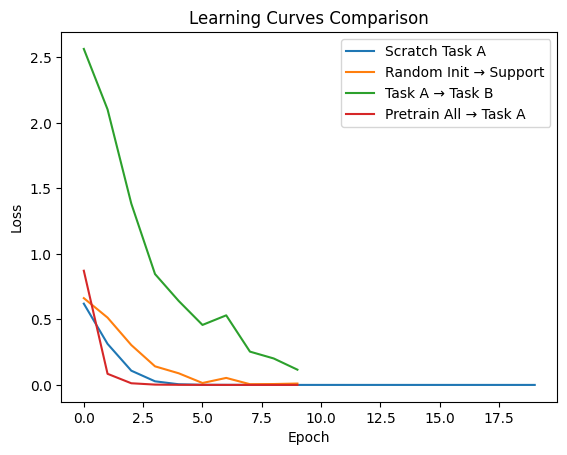

In [15]:
#Analysis and Plots
plt.plot(loss_A, label="Scratch Task A")
plt.plot(loss_rand_A, label="Random Init → Support")
plt.plot(loss_A_to_B, label="Task A → Task B")
plt.plot(loss_pretrain_A, label="Pretrain All → Task A")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves Comparison")
plt.show()

In [16]:
def compute_metrics(model, dataloader):
    model.eval()

    TP = FP = TN = FN = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)

            TP += ((preds == 1) & (y == 1)).sum().item()
            TN += ((preds == 0) & (y == 0)).sum().item()
            FP += ((preds == 1) & (y == 0)).sum().item()
            FN += ((preds == 0) & (y == 1)).sum().item()

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1
results = {}

results["Scratch Task A"] = compute_metrics(model_A, query_loader_A)
results["Random Init → Support A"] = compute_metrics(model_random_A, query_loader_A)
results["Task A → Task B"] = compute_metrics(model_taskA, query_loader_B)
results["Pretrain All → Support A"] = compute_metrics(model_pretrain, query_loader_A)
print(f"{'Method':30s} | Acc | Prec | Recall | F1")
print("-" * 70)

for method, (acc, prec, rec, f1) in results.items():
    print(f"{method:30s} | {acc:.3f} | {prec:.3f} | {rec:.3f} | {f1:.3f}")

Method                         | Acc | Prec | Recall | F1
----------------------------------------------------------------------
Scratch Task A                 | 0.900 | 1.000 | 0.800 | 0.889
Random Init → Support A        | 0.900 | 1.000 | 0.800 | 0.889
Task A → Task B                | 0.800 | 1.000 | 0.600 | 0.750
Pretrain All → Support A       | 1.000 | 1.000 | 1.000 | 1.000


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



The best strategy in Method 2 is pretraining on all digits followed by fine-tuning, as it provides a broad and reusable feature representation that allows rapid adaptation with few samples. During fine-tuning, although the model has already seen the data, the task objective changes from multi-class to binary classification, requiring adjustment of decision boundaries rather than relearning features. Using a digit classifier for letter classification would not work directly due to domain mismatch, unless domain-invariant features are learned. In this assignment, meta-learning was not explicitly used; we only explored transfer learning. MAML aims to learn an initialization that can quickly adapt to multiple dissimilar tasks, such as digits and letters, using only a few gradient steps.

# ALL THE BEST !